# Lead-lag 
Lead-lag between eastern SPG Salinity and density (DENS) for 1960-2016.

In [1]:
import numpy as np
import xarray as xr
import pandas as pd

from scipy import signal
from scipy import stats

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
def shift(arr, num, fill_value=np.nan):
    if num == 0:
        return arr
    elif num > 0:
        return np.concatenate((np.full(num, fill_value), arr[:-num]))
    else:
        return np.concatenate((arr[-num:], np.full(-num, fill_value)))

### Load `DENS`

In [3]:
df_dens = pd.read_csv('../indices/DENS_detrend.csv')
df_dens.time = pd.DatetimeIndex(df_dens.time)

In [4]:
df_dens = df_dens[(df_dens.time>='1993-01-15')&(df_dens.time<='2016-12-15')].reset_index()

In [5]:
df_dens.tail()

,index,time,DENS_detrend
283,1399,2016-08-15,0.018807
284,1400,2016-09-15,0.028073
285,1401,2016-10-15,0.016454
286,1402,2016-11-15,0.022105
287,1403,2016-12-15,0.032009


### Load HadOBS EN4 salinity

In [6]:
ds = xr.open_dataset('/home/jet/data/hadobs/converted/en4/salinity.nc')

In [7]:
# Add area
nc = xr.open_dataset('/home/jet/data/hadobs/hadobs_en4_area.nc')
ds['area'] = nc.area
ds.area.attrs= {'units': 'm^2','long_name': 'Grid area'}

In [8]:
tstart = '1993-01-15'
tend = '2016-12-15'

south = 53
north = 62
west = -26
east = -10

### Subsample salinty to new array

In [9]:
psal = ds.salinity.sel(time=slice(tstart,tend),lat=slice(south,north),lon=slice(west,east))

### Depth-average salinity (top 491 m)

In [10]:
upper = 0
lower = 500

In [11]:
depth_bnds = ds.depth_bnds.sel(depth=slice(upper,lower))

In [12]:
print 'upper:',  str(depth_bnds[0,0].values)
print 'lower:', str(depth_bnds[-1,1].values)

upper: 0.0
lower: 490.9494


In [13]:
dz = (depth_bnds[:,1]-depth_bnds[:,0])

In [14]:
H = ((psal/psal)*dz).sum('depth')

In [15]:
psal_avg = (psal * dz).sum('depth')/H

In [16]:
print str(psal_avg.time.values[0])[:10]
print str(psal_avg.time.values[-1])[:10]

1993-01-15
2016-12-15


### Calculate spatial mean

In [17]:
area = ((psal_avg/psal_avg)*ds.area).sum(dim=['lat','lon'])

In [18]:
psal_mean = (psal_avg * ds.area/area).sum(dim=['lat','lon'])

### Calculate seasonal anomaly

In [19]:
psal_sanom = psal_mean.groupby('time.month') - psal_mean.groupby('time.month').mean('time')

### Detrend

In [20]:
psal_detrend = xr.DataArray(signal.detrend(psal_sanom),coords=[psal_sanom.time],dims=['time'])

### Normalize

In [21]:
psal_norm = (psal_detrend - psal_detrend.mean())/psal_detrend.std()

### Convert to dataframe

In [22]:
# Convert to dataframe
df = psal_norm.to_dataframe(name='sal').reset_index()

In [23]:
df.time = pd.DatetimeIndex(df_dens.time)

In [24]:
df['dens'] = (df_dens.DENS_detrend - np.mean(df_dens.DENS_detrend))/np.std(df_dens.DENS_detrend)

In [25]:
df.head()

,time,sal,dens
0,1993-01-15,-1.656543,0.657447
1,1993-02-15,-1.328362,0.993701
2,1993-03-15,-1.162133,0.181379
3,1993-04-15,-1.208048,0.788729
4,1993-05-15,-1.663267,0.542150


In [26]:
df.tail()

,time,sal,dens
283,2016-08-15,-2.650344,0.605082
284,2016-09-15,-2.681650,0.982936
285,2016-10-15,-2.493674,0.509138
286,2016-11-15,-2.455984,0.739548
287,2016-12-15,-2.293436,1.143406


In [27]:
df['year'] = pd.DatetimeIndex(df.time).year

In [28]:
df = df[['year','dens','sal']].groupby(['year']).mean()

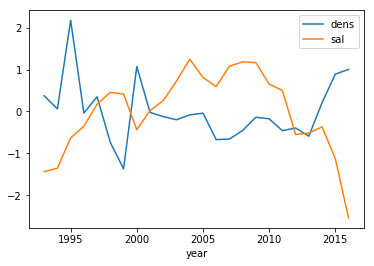

In [29]:
df.plot()

In [30]:
df.head()

,dens,sal
year,,
1993,0.374954,-1.437445
1994,0.062060,-1.353621
1995,2.179362,-0.631350
1996,-0.036678,-0.353905
1997,0.350201,0.175495


In [31]:
lag = 1
df['dens_lag'] = np.concatenate([df.dens[lag:],lag*[np.nan]])
df['sal_lag'] = np.concatenate([df.sal[lag:],lag*[np.nan]])

In [32]:
x = df.sal
y1 = df.sal_lag
y2 = df.dens_lag
y3 = df.dens

maxlag = 5

corrs_y1 = []
corrs_y2 = []
corrs_y3 = []

pvals_y1 = []
pvals_y2 = []
pvals_y3 = []

lags = np.arange(-maxlag,maxlag+1)
for lag in lags:
    _y1 = shift(y1,lag)
    _y2 = shift(y2,lag)
    _y3 = shift(y3,lag)
    
    not_nan_ind = ~np.isnan(_y1)
    (corr_y1, pval_y1) = stats.pearsonr(x[not_nan_ind],_y1[not_nan_ind])
    corrs_y1.append(corr_y1)
    pvals_y1.append(pval_y1)
    
    not_nan_ind = ~np.isnan(_y2)
    (corr_y2, pval_y2) = stats.pearsonr(x[not_nan_ind],_y2[not_nan_ind])
    corrs_y2.append(corr_y2)
    pvals_y2.append(pval_y2)
    
    not_nan_ind = ~np.isnan(_y3)
    (corr_y3, pval_y3) = stats.pearsonr(x[not_nan_ind],_y3[not_nan_ind])
    corrs_y3.append(corr_y3)
    pvals_y3.append(pval_y3)

corrs_y1 = np.array(corrs_y1)
corrs_y2 = np.array(corrs_y2)
corrs_y3 = np.array(corrs_y3)

pvals_y1 = np.array(pvals_y1)
pvals_y2 = np.array(pvals_y2)
pvals_y3 = np.array(pvals_y3)

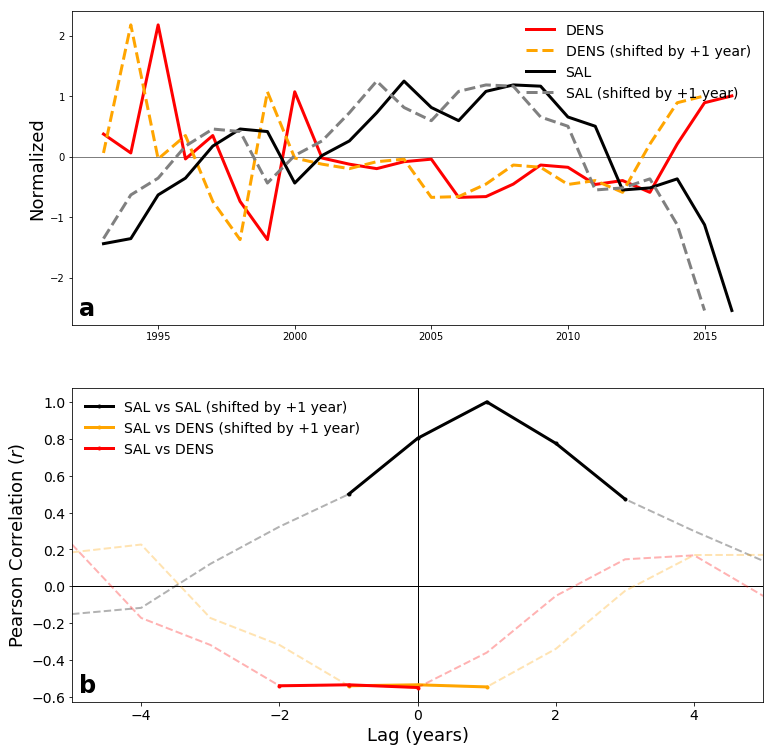

In [36]:
fig, ax = plt.subplots(figsize=(12,12))
plt.axis('off')

ax1 = fig.add_subplot(211)
ax1.text(0.01,0.03, 'a', transform=ax1.transAxes, fontsize=24, fontweight='bold')
ax1.axhline(y=0, xmin=0, xmax=1, linewidth=0.5, color = 'k')
ax1.plot(df.index, df.dens, lw=3, color='r',linestyle='-',label='DENS')
ax1.plot(df.index, df.dens_lag, lw=3, color='orange',linestyle='--',label='DENS (shifted by +1 year)')
ax1.plot(df.index, df.sal, lw=3, color='k',linestyle='-',label='SAL')
ax1.plot(df.index, df.sal_lag, lw=3, color='grey',linestyle='--',label='SAL (shifted by +1 year)')

#ax1.set_xlim([1959,2017])
#ax1.set_xticks(np.arange(1960,2020,5))
#for tick in ax1.xaxis.get_major_ticks():
#    tick.label.set_fontsize(14)
#ax1.set_ylim([-3,3])
#ax1.set_yticks(np.arange(-3,4,1))
#for tick in ax1.yaxis.get_major_ticks():
#    tick.label.set_fontsize(14)   
ax1.set_ylabel('Normalized',fontsize=18)
ax1.legend(loc='upper right',frameon=False, fontsize=14)

ax2 = fig.add_subplot(212)
ax2.text(0.01,0.03, 'b', transform=ax2.transAxes, fontsize=24, fontweight='bold')
ax2.axhline(0, color='black', lw=1)
ax2.axvline(0, color='black', lw=1)
ax2.plot(lags, corrs_y1,lw=2, linestyle='--', c='k',alpha=0.3,label='_nolegend_')
ax2.plot(np.where(pvals_y1 < 0.05, lags, np.nan), np.where(pvals_y1 < 0.05, corrs_y1, np.nan),
         lw=3, linestyle='-', marker='.', c='k',label='SAL vs SAL (shifted by +1 year)')
ax2.plot(lags, corrs_y2,lw=2, linestyle='--', c='orange',alpha=0.3,label='_nolegend_')
ax2.plot(np.where(pvals_y2 < 0.05, lags, np.nan), np.where(pvals_y2 < 0.05, corrs_y2, np.nan),
         lw=3, linestyle='-', marker='.', c='orange',label='SAL vs DENS (shifted by +1 year)')
ax2.plot(lags, corrs_y3,lw=2, linestyle='--', c='r',alpha=0.3,label='_nolegend_')
ax2.plot(np.where(pvals_y3 < 0.05, lags, np.nan), np.where(pvals_y3 < 0.05, corrs_y3, np.nan),
         lw=3, linestyle='-', marker='.', c='r',label='SAL vs DENS')
ax2.set_xlim([-maxlag,maxlag])
#ax2.set_ylim([-0.75,0.3])
#ax2.set_xticks(np.arange(-maxlag,maxlag+1,1))
for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)  
#ax2.set_yticks(np.arange(-0.7,0.4,0.1))
for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
ax2.set_ylabel(r'Pearson Correlation ($r$)',fontsize=18)
ax2.set_xlabel(r'Lag (years)',fontsize=18)
ax2.legend(loc='upper left',frameon=False, fontsize=14)

fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9)
plt.show()

Positive lags indicate that y1, y2 or y3 is leading and negative lags indicate that x (`SAL`) is leading.